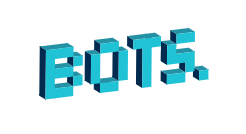

# How To Make A Bot
#### A step by step guide - Part 1
<p>&nbsp;</p>



### Introduction 

This notebook is the first in a series showing what is involved in making and testing a Bot.

We'll begin with getting historical marketdata which we can use in developing and testing bots. We will then see how a bot could process marketdata to generate a simple buy or sell signal.
Once we have a bot that generates signals, we can estimate how well it would have performed had it traded on those signals; this is called backtesting.


### Get historical data

In general, Bots work with marketdata represented in 'bars'. A bar records the Open, High, Low and Last price in a fixed time window. For example, a bot that has a low trading frequency could work with day bars, while a bot that sends multiple trading signals during a day could work with hour bars.
Historical market data can be requested from the different exchanges like Poloniex and Binance or third-party providers; how this is done is shown in the next notebook. In this notebook we will read 100 days of 30 minute bars for the Btc/Eth pair from a file. Having a fixed dataset during development avoids exceeding the request limit that frequently apply with data providers, and makes it easier to compare the performance of different versions of a bot.

The Bot Tool library contains functions to facilitate bot development; we will use it to read the data.

#### Importing the Bot tools:

In [ ]:
import botslib.Bot_tools as bt

In [ ]:
# Use the Bot tools 'read_historical_data' to get the data
BTC_ETH_Bars = bt.read_historical_data()
# Show the first 5 lines of the data
BTC_ETH_Bars.head()

In [ ]:
# Use the Bot tools function 'plot_bars' to take a look at the bars (the last 25 in this case)
bt.plot_bars(BTC_ETH_Bars[-25:])

### Signal Generation

Now that we have some data, we can make a function that will take this data as input, and generate a signal based on it. Such a function would form the basis of a bot.
The signal we will generate here is based on the difference between a fast- and a slow moving average of the close price. When the fast moving average crosses the slow moving average in an upward direction, we generate a **'buy'** signal, if it crosses in a downward direction, we generate a **'sell'** signal.

For the **fast MA** (moving average) we use the 5 last close prices, for the **slow MA** we use the last 15.

In [ ]:
close_prices = BTC_ETH_Bars['close'].values
# Use the Bot tools function 'calc_sma' to calculate the moving averages
fast_ma = bt.calc_sma(close_prices, 5)
slow_ma = bt.calc_sma(close_prices , 15)

In [ ]:
# Use the Bot tools function 'plot_lines' to visualize (part off) the series
bt.plot_lines([close_prices,fast_ma,slow_ma],['Close', 'Fast', 'Slow'], 1150,1250)

Looks like this strategy could generate some valid signals, at least for this section of the data.
The function we will write takes as input the available bars, and returns a '***buy***', '***sell***' or '***none***' signal.

In [ ]:
def get_signal(bars):

    FAST = 5
    SLOW = 15

    if len(bars) < SLOW:
        # If not enough bars available, return None
        return 'none'

    close_prices = bars['close'].values
    fast_ma = bt.calc_sma(close_prices, FAST)
    slow_ma = bt.calc_sma(close_prices , SLOW)
    
    last_fast = fast_ma[-1]
    previous_fast = fast_ma[-2]
    last_slow = slow_ma[-1]
    previous_slow = slow_ma[-2]

    if last_fast > last_slow and previous_fast < previous_slow:
        return 'buy'
    elif last_fast < last_slow and previous_fast > previous_slow:
        return 'sell'
    else:
        return 'none'
    
# Tip: try some other values for the FAST and SLOW variables and see how it affects performance

### Backtesting

Now that we have the historical data and we have a signal generator (bot), we can estimate how the bot would have performed. We will use the RevenYOU backtester for this purpose. The backtester will cycle through all bars, and calls our ***'get_signal'*** function on each iteration. It then simulates position changes based on the signal. When it is done, it prints out the final equity, net profit and max drawdown. It also shows the benchmark performance; this is simply the performance that would have been achieved by holding the equity from the start. 

In [ ]:
from youengine.youengine import YouEngine

youengine = YouEngine()

perf = youengine.run(data=BTC_ETH_Bars, bot=get_signal, capital_base=10, pair='BTC_ETH', analyze=False)


**The bot made a profit!** It is a small profit, but substantially better then not doing anything at all (the benchmark).  
This leads us to another interesting experiment: What if we had a monkey that would randomly press a buy, sell or none button? Would it out-perform our moving average strategy? Let's create a monkey bot, and backtest it on the same data.

In [ ]:
import random

def monkey_signal(bars):
    # The monkey thinks it knows best, and makes it's decision without looking at the bars
    action = random.randint(0,3)
    if action == 0:
        return 'none'
    if action == 1:
        return 'buy'
    if action == 2:
        return 'sell'


In [ ]:
perf = youengine.run(data=BTC_ETH_Bars, bot=monkey_signal, capital_base=10, pair='BTC_ETH', analyze=False)

It did not out-perform our moving average strategy, but it performed much better then the benchmark; amazing.
Every time the monkey bot is run, it's performance will vary (since it is a random process). We can not exclude the possibility that it will sometimes out-perform a well thought out strategy; chances are very slim though.
***

Question or comments? Let me know: <philip@revenyou.io>